In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import os 
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")

from config import BASELINE_META_MODEL_DIR, BASELINE_META_MODEL_DIR
from meta_data_utils import sanitize_filename, get_meta_data
from data_utils import load_data, get_date_columns, check_stationarity, get_page_to_article_domain_mapping
from plot_utils import plot_stacked_time_series

In [3]:
data = load_data(transpose=True, remove_inactive_articles=True)
date_columns = get_date_columns()

In [4]:
data.shape

(803, 115084)

In [33]:
sampled_pages = data.sample(n=50, axis=1, random_state=130)

sampled_pages.head()

page,Sarah_Silverman_en.wikipedia.org_all-access_all-agents,Mario_Götze_es.wikipedia.org_all-access_all-agents,Chris_Rock_en.wikipedia.org_all-access_all-agents,ポケットモンスター_(劇場版)_ja.wikipedia.org_all-access_all-agents,B-52_(航空機)_ja.wikipedia.org_all-access_spider,慈禧太后_zh.wikipedia.org_mobile-web_all-agents,List_of_radars_en.wikipedia.org_all-access_all-agents,おかもとまり_ja.wikipedia.org_mobile-web_all-agents,Сименс_(единица_измерения)_ru.wikipedia.org_all-access_all-agents,ホキ_ja.wikipedia.org_desktop_all-agents,...,Radiohead_fr.wikipedia.org_all-access_all-agents,Urknall_de.wikipedia.org_mobile-web_all-agents,Memento_(film)_en.wikipedia.org_all-access_all-agents,青山テルマ_ja.wikipedia.org_all-access_spider,Berserk_(manga)_en.wikipedia.org_desktop_all-agents,"Иванова,_Анастасия_Семёновна_ru.wikipedia.org_mobile-web_all-agents",Manual:Importing_XML_dumps_www.mediawiki.org_desktop_all-agents,Alexander_Bommes_de.wikipedia.org_desktop_all-agents,Milchstraße_de.wikipedia.org_all-access_all-agents,MediaWiki_1.26_www.mediawiki.org_desktop_all-agents
2015-07-01,5153.0,747.0,3193.0,880.0,16.0,271.0,290.0,340.0,59.0,143.0,...,259.0,288.0,2671.0,8.0,1592.0,71.0,87.0,185.0,885.0,22.0
2015-07-02,5113.0,703.0,3737.0,945.0,7.0,331.0,260.0,276.0,65.0,122.0,...,288.0,322.0,2440.0,3.0,1551.0,73.0,88.0,179.0,819.0,29.0
2015-07-03,5354.0,546.0,3605.0,1196.0,14.0,303.0,197.0,234.0,60.0,150.0,...,275.0,335.0,2345.0,2.0,1419.0,73.0,72.0,445.0,817.0,27.0
2015-07-04,4937.0,915.0,3412.0,1284.0,10.0,271.0,225.0,255.0,42.0,64.0,...,303.0,422.0,2550.0,4.0,1375.0,63.0,66.0,303.0,759.0,10.0
2015-07-05,5370.0,1061.0,3455.0,1430.0,11.0,369.0,186.0,214.0,37.0,44.0,...,309.0,472.0,2803.0,3.0,1488.0,68.0,80.0,114.0,1037.0,10.0


In [18]:
get_meta_data('Sarah_Silverman_en.wikipedia.org_all-access_all-agents').head()

,total_edits,total_bytes_added,unique_editors,mobile edit,mobile web edit,visualeditor,mw-reverted,mobile app edit,contenttranslation,visualeditor-switched,end_of_day_size
date,,,,,,,,,,,
2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55234.0
2015-07-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55234.0
2015-07-03,3.0,367.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55601.0
2015-07-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55601.0
2015-07-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55601.0


### Baseline ARIMAX with Meta Data

In [26]:
def fit_arima(series, p, d, q, exog=None):
    model = ARIMA(series, exog=exog, order=(p, d, q))
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            fitted_model = model.fit()
    except Exception as e:
        print(f"Fitting ARIMA({p},{d},{q}) failed with default start parameters: {e}")
        # Retry with initial parameters set to zero
        fitted_model = model.fit(start_params=[0] * (p + q))
    return fitted_model


def find_best_arima_model(time_series, p_values, d_values, q_values, exog=None):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = fit_arima(time_series, p, d, q, exog)
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        best_model = model
                except Exception as e:
                    print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
    
    return {"order": best_order, "model": best_model, "aic": best_aic}

In [27]:
def get_time_series_and_exog(data, page_name):
    time_series = data[page_name]
    time_series = time_series.asfreq('D')

    meta_df = get_meta_data(page_name)
    # Ensure the index is set to 'date'
    if meta_df.index.name != 'date':
        meta_df.set_index('date', inplace=True)

    # Ensure that the exog features are aligned with the time series data
    exog = meta_df.reindex(time_series.index).asfreq('D').fillna(0)
    
    return time_series, exog

def train_test_split(series, exog, test_size):
    train = series[:-test_size]
    test = series[-test_size:]
    train_exog = exog[:-test_size]
    test_exog = exog[-test_size:]
    return train, test, train_exog, test_exog

In [28]:
def process_page(page_name, data, date_columns, p_values, d_values, q_values, test_size):
    print(f"Processing ARIMA models for page: {page_name}")
        
    # Get the time series data for the page
    time_series, exog = get_time_series_and_exog(data, page_name)
    
    # Skip the current iteration if no data was found
    if time_series is None:
        return

    # Determine if the series is stationary
    is_stationary = check_stationarity(time_series)

    # Adjust d_values based on stationarity
    adjusted_d_values = [0] if is_stationary else d_values

    # Split the data into training and testing sets
    train_series, test_series, train_exog, test_exog =  train_test_split(time_series, exog, test_size)

    # Find the best ARIMA model for the time series
    best_model_info = find_best_arima_model(train_series, p_values, adjusted_d_values, q_values, exog=train_exog)
    
    print(f"Best ARIMA model for {page_name}: Order={best_model_info['order']} AIC={best_model_info['aic']:.2f}")

    return best_model_info


def process_all_pages(data, date_columns, p_values, d_values, q_values, test_size):
    results = {}
    
    # Iterate over all unique pages in the DataFrame
    for page_name in data.columns:
        best_model_info = process_page(page_name, data, date_columns, p_values, d_values, q_values, test_size)
        if best_model_info is not None:
            results[page_name] = best_model_info

    return results

In [48]:
p_values = [0, 1, 30]
d_values = [0, 1]
q_values = [0, 1, 30]

test_size = 30
best_models_per_page = process_all_pages(sampled_pages, date_columns, p_values, d_values, q_values, test_size)

Processing ARIMA models for page: Sarah_Silverman_en.wikipedia.org_all-access_all-agents
Best ARIMA model for Sarah_Silverman_en.wikipedia.org_all-access_all-agents: Order=(1, 0, 1) AIC=15088.61
Processing ARIMA models for page: Mario_Götze_es.wikipedia.org_all-access_all-agents
Best ARIMA model for Mario_Götze_es.wikipedia.org_all-access_all-agents: Order=(1, 0, 1) AIC=11537.28
Processing ARIMA models for page: Chris_Rock_en.wikipedia.org_all-access_all-agents
Best ARIMA model for Chris_Rock_en.wikipedia.org_all-access_all-agents: Order=(1, 0, 1) AIC=15679.47
Processing ARIMA models for page: ポケットモンスター_(劇場版)_ja.wikipedia.org_all-access_all-agents
Best ARIMA model for ポケットモンスター_(劇場版)_ja.wikipedia.org_all-access_all-agents: Order=(1, 0, 30) AIC=11368.35
Processing ARIMA models for page: B-52_(航空機)_ja.wikipedia.org_all-access_spider
Best ARIMA model for B-52_(航空機)_ja.wikipedia.org_all-access_spider: Order=(1, 0, 0) AIC=11566.83
Processing ARIMA models for page: 慈禧太后_zh.wikipedia.org_mobi

In [ ]:
sampled_pages

In [50]:
len(best_models_per_page)

50

In [53]:
os.makedirs(BASELINE_META_MODEL_DIR, exist_ok=True)

# Save each model separately
for page, model_info in best_models_per_page.items():
    model = model_info['model']
    file_name = f"{page.replace('/', '_').replace(':', '_')}.pkl" 
    file_path = os.path.join(BASELINE_META_MODEL_DIR, file_name)
    
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)

print("Models have been successfully saved.")

Models have been successfully saved.


In [54]:
def smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))


def forecast_test(model, test_series, test_exog):
    forecast = model.get_forecast(steps=len(test_series), exog=test_exog)
    forecast_index = pd.date_range(start=test_series.index[0], periods=len(test_series), freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    return forecast_series

def evaluate_model_performance(model, data, page_name, test_size):
    
    time_series, exog = get_time_series_and_exog(data, page_name)
    train_series, test_series, train_exog, test_exog = train_test_split(time_series, exog, test_size)
    forecast_series = forecast_test(model, test_series, test_exog)
    sMAPE_value = smape(test_series, forecast_series)
    return sMAPE_value

def evaluate_all_models(best_models_per_page, data, test_size=30):
    page_to_sMAPE = {}
    for page_name, best_model_dict in best_models_per_page.items():
        model = best_model_dict['model']
        if model:
            sMAPE = evaluate_model_performance(model, data, page_name, test_size)
            page_to_sMAPE[page_name] = sMAPE
    return page_to_sMAPE

In [55]:
page_to_sMAPE = evaluate_all_models(best_models_per_page, sampled_pages)

page_w_min_sMAPE = None
page_w_max_sMAPE = None
min_sMAPE = np.inf
max_sMAPE = 0
total = 0
for page, sMAPE in page_to_sMAPE.items():
    total += sMAPE
    if sMAPE < min_sMAPE:
        page_w_min_sMAPE = page
        min_sMAPE = sMAPE

    if sMAPE > max_sMAPE:
        page_w_max_sMAPE = page
        max_sMAPE = sMAPE

print(f'Average sMAPE is {total / len(page_to_sMAPE):.2f}%')

Average sMAPE is 48.24%


In [56]:
def check_residuals(model):
    residuals = model.resid
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    residuals.plot(ax=ax[0], title="Residuals")
    residuals.plot(kind='kde', ax=ax[1], title="Density")
    plt.show()
    
def plot_forecast_vs_actual(train_series, test_series, train_exog, test_exog, model, plot_only_test=False):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    if not plot_only_test:
        ax.plot(train_series, label='Train', color='blue', linewidth=1)
        # In-sample forecast
        in_sample_forecast = model.fittedvalues
        ax.plot(in_sample_forecast, label='In-sample Forecast', color='green', linestyle='--', linewidth=2)

    ax.plot(test_series, label='Test', color='orange', linewidth=1)
    # Out-of-sample forecast
    forecast = model.get_forecast(steps=len(test_series), exog=test_exog)
    forecast_index = pd.date_range(start=test_series.index[0], periods=len(test_series), freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    ax.plot(forecast_series, label='Out-of-sample Forecast', color='red', linestyle='--', linewidth=2)

    sMAPE_value = smape(test_series, forecast_series)
    print(f'sMAPE: {sMAPE_value:.2f}%')
    
    # Adding titles and labels
    ax.set_title('Actual vs Forecasted Values', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Page Views', fontsize=14)
    
    # Adding legend
    ax.legend(loc='upper left', fontsize=12)
    
    # Adding grid for better readability
    ax.grid(True)
    
    # Improving the appearance
    plt.tight_layout()
    
    plt.show()

def plot_model_forecast(data, best_models_per_page, date_columns, page_name, test_size):
    if page_name not in best_models_per_page:
        print(f"No model found for page: {page_name}")
        return
    
    best_model_info = best_models_per_page[page_name]
    model = best_model_info['model']
    
    time_series, exog = get_time_series_and_exog(data, page_name)
    
    if time_series is not None:
        train_series, test_series, train_exog, test_exog = train_test_split(time_series, exog, test_size)
        plot_forecast_vs_actual(train_series, test_series, train_exog, test_exog, model, plot_only_test=True)
        check_residuals(model)

### Page with Minimum sMAPE

sMAPE: 10.24%


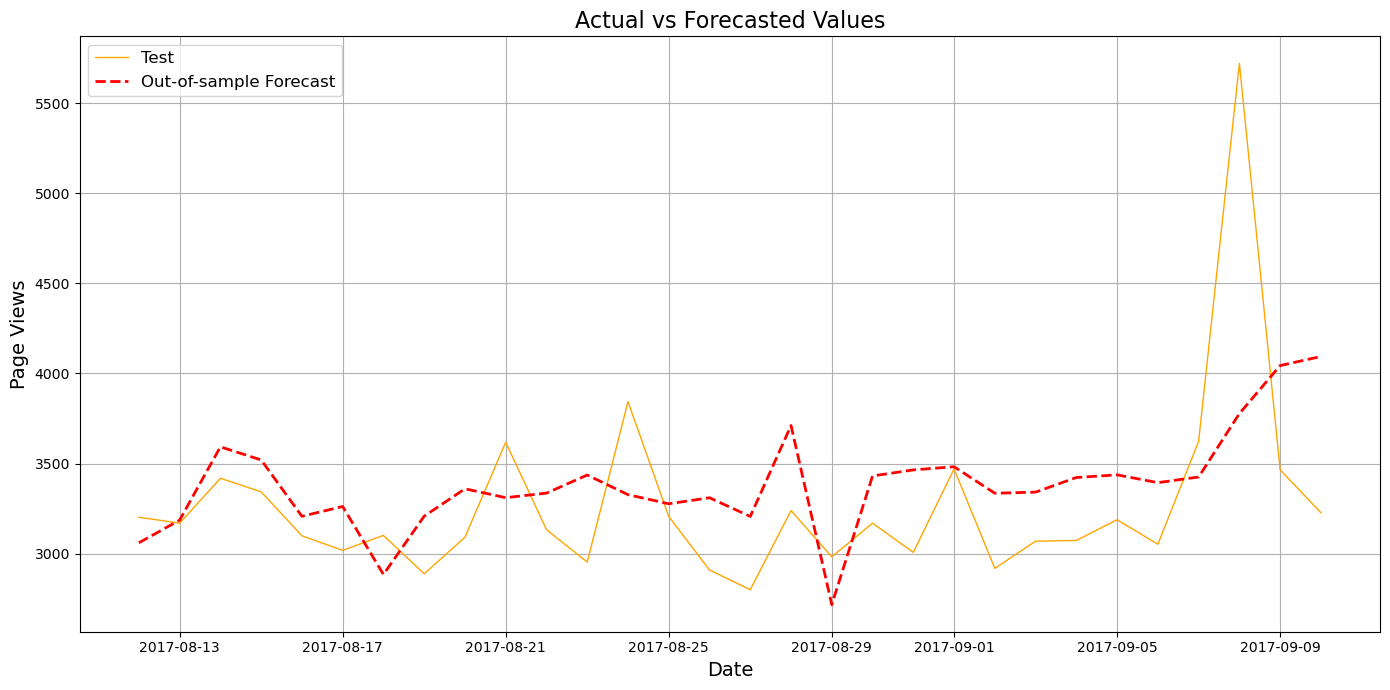

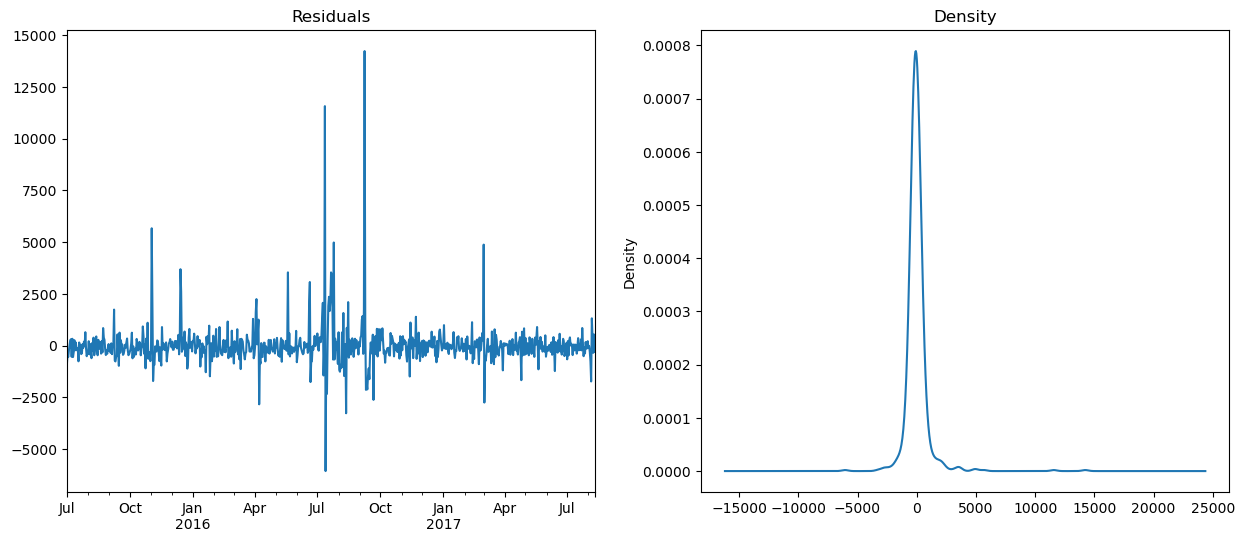

In [57]:
plot_model_forecast(sampled_pages, best_models_per_page, date_columns, page_w_min_sMAPE, test_size)

### Page with Maximum sMAPE

sMAPE: 185.74%


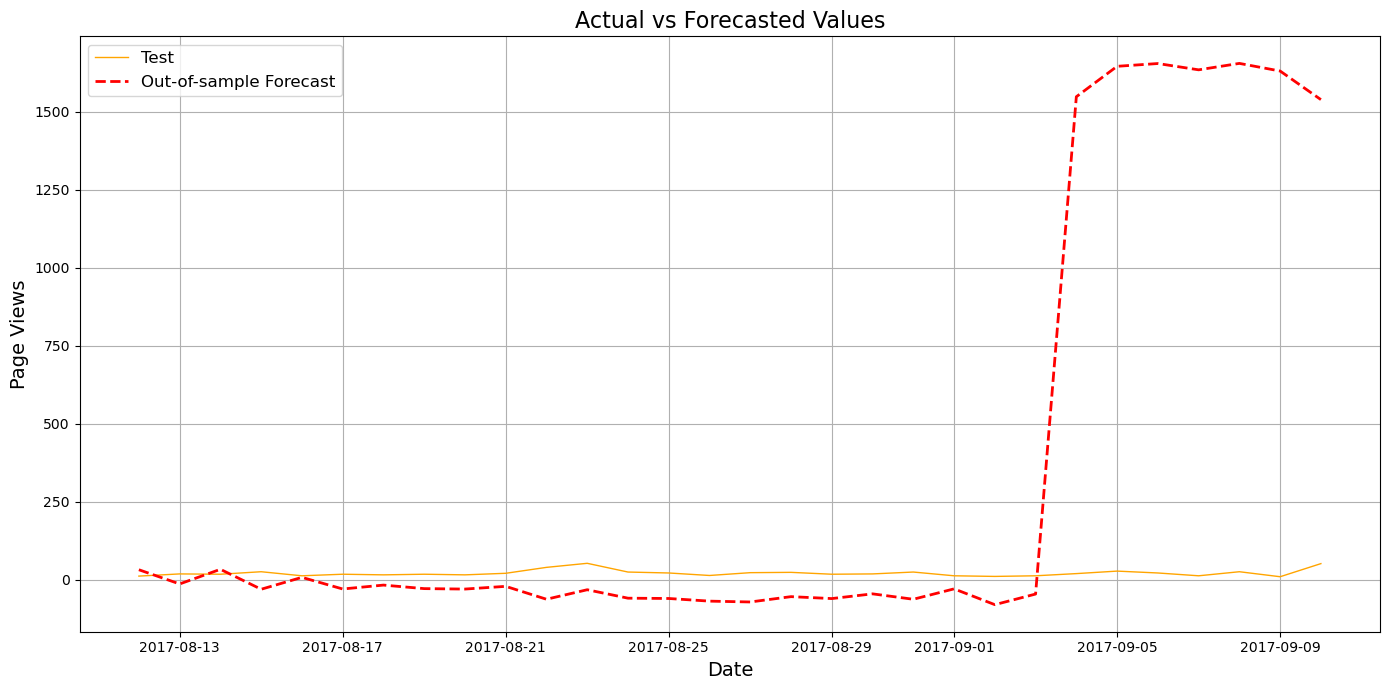

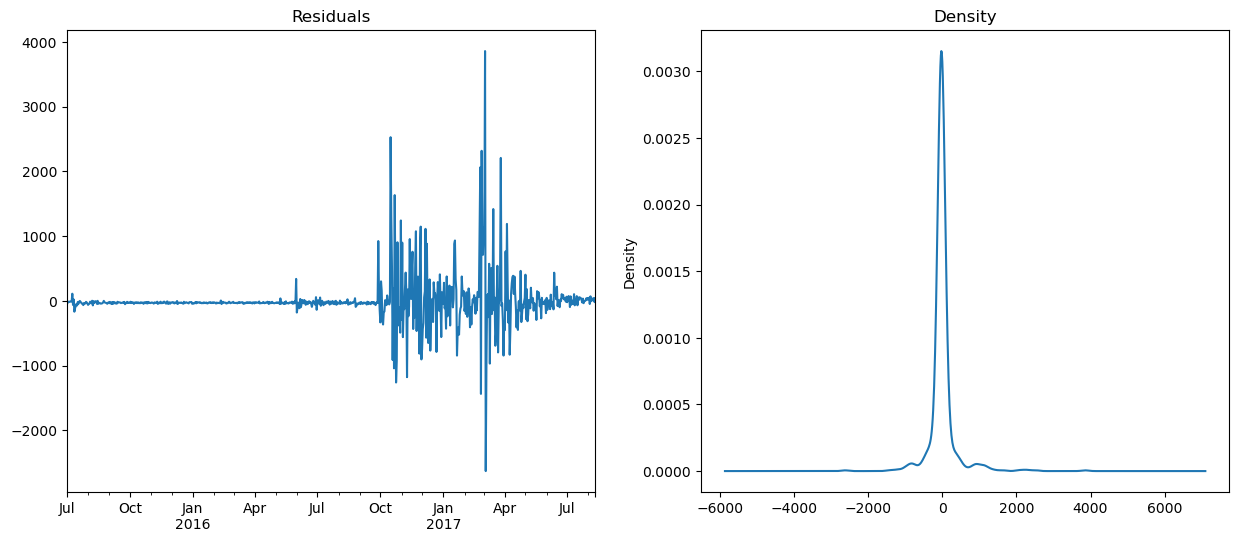

In [58]:
plot_model_forecast(sampled_pages, best_models_per_page, date_columns, page_w_max_sMAPE, test_size)

In [59]:
sampled_pages.to_csv(os.path.join(BASELINE_META_MODEL_DIR, 'data.csv'), index_label='date')